In [4]:
import numpy as np
import matplotlib.pyplot as plt
import spectral as sp
import pandas as pd
from scipy.io import loadmat

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import scikitplot as skplt
from sklearn.metrics import classification_report, accuracy_score
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.preprocessing import LabelBinarizer

In [5]:
def count_occurrence(arr):
    """
    Count the occurrence of each unique element in the given array.

    Parameters:
    arr (numpy.ndarray): The input array.

    Returns:
    None
    """
    unique_elements, counts = np.unique(arr, return_counts=True)
    for element, count in zip(unique_elements, counts):
        print(f"{element} = {count}")

## Indian Pines

In [6]:
"""
Load and process Indian Pines dataset and groundtruth.
"""
in_ = np.load("indianpinearray.npy")
out_ = np.load("IPgt.npy")

r_in, c_in, band = in_.shape
r_out, c_out = out_.shape
c = np.unique(out_)

print(f'Dataset Shape: {r_in, c_in, band}\nGroundtruth Shape: {r_out, c_out}\nNumber of Bands: {band}\nClasses: {c}')
count_occurrence(out_)

Dataset Shape: (145, 145, 200)
Groundtruth Shape: (145, 145)
Number of Bands: 200
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0 = 10776
1 = 46
2 = 1428
3 = 830
4 = 237
5 = 483
6 = 730
7 = 28
8 = 478
9 = 20
10 = 972
11 = 2455
12 = 593
13 = 205
14 = 1265
15 = 386
16 = 93


In [7]:
def show_img(img, title):
    """
    Display an image with a colorbar and title.
    Parameters:
    img (numpy.ndarray): The image to be displayed.
    title (str): The title of the image.
    """
    plt.figure(figsize=(6, 4))
    sp.imshow(img, (145, 145, 199), stretch=(0.01, 0.99))
    plt.colorbar(label='Reflectance')
    plt.title(title)
    plt.show()

def plot_band(img, band):
    """
    Plot a band of the image.

    Parameters:
    img (numpy.ndarray): The image to be displayed.
    band (int): The band to be plotted.
    """
    plt.figure(figsize=(6, 4))
    plt.imshow(img[:, :, band], cmap='jet')
    plt.colorbar(label='Reflectance')
    plt.title(f'Band {band}')
    plt.show()

def plot_groundtruth_classes(out_):
    """
    Plot the groundtruth classes.

    Parameters:
    out_ (numpy.ndarray): The array containing the groundtruth classes.
    """
    plt.figure(figsize=(7, 5))
    plt.imshow(out_, cmap='jet')
    plt.colorbar(label='Class')
    plt.title('Groundtruth Classes')
    plt.show()


def overlay_plot(img, gt):
    """
    Plot the image with the groundtruth overlayed.
    Parameters:
    img (numpy.ndarray): The image to be displayed.
    gt (numpy.ndarray): The array containing the groundtruth classes.
    """
    view = sp.imshow(img, (30, 20, 10), classes=gt)
    view.set_display_mode('overlay')
    view.class_alpha = 0.5
    view.set_title('Overlay Plot')


c:\Users\aiqia\anaconda3\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


<Figure size 600x400 with 0 Axes>

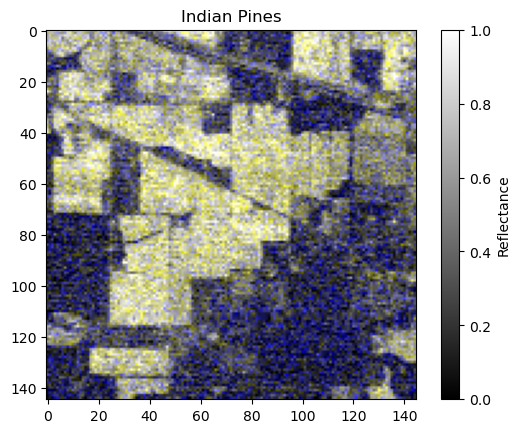

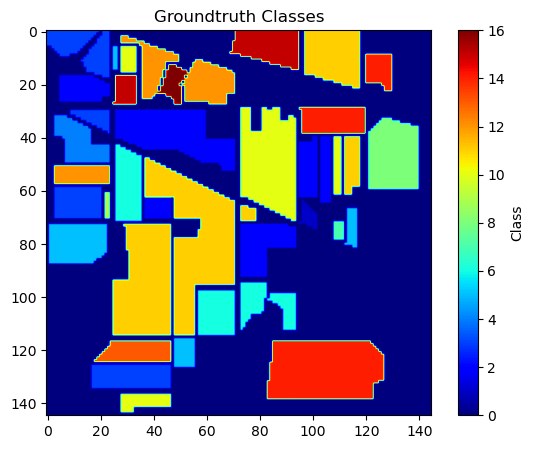

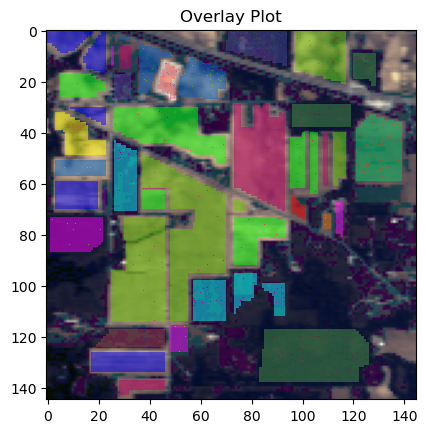

In [8]:
img = in_
gt = out_
show_img(img, 'Indian Pines')
plot_groundtruth_classes(out_)
overlay_plot(img, gt)

In [9]:
def scale_image(img, scaler=StandardScaler()):
    """
    Reshapes and scales the input image using MinMaxScaler() or StandardScaler()

    Parameters:
    img (ndarray): The input image array.

    Returns:
    ndarray: The scaled image array.
    """

    img_reshaped = img.reshape(-1, img.shape[-1])

    img_scaled = scaler.fit_transform(img_reshaped)
    img_scaled = img_scaled.reshape(img.shape)

    return img_scaled


In [10]:
def pca(img, n_components=3):
    """
    Performs PCA on the input image.

    Parameters:
    img (ndarray): The input image array.
    n_components (int): The number of components to be returned.

    Returns:
    ndarray: The transformed image array.
    """
    pc = sp.principal_components(img)
    sp.imshow(pc.cov, title='Covariance Matrix')

    pc_0999 = pc.reduce(fraction=0.999)
    pcc = len(pc_0999.eigenvalues)

    img_pc = pc_0999.transform(img)
    sp.imshow(img_pc[:, :, :3], stretch_all=True, title='Transformed Image')

    return pcc, img_pc


c:\Users\aiqia\anaconda3\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


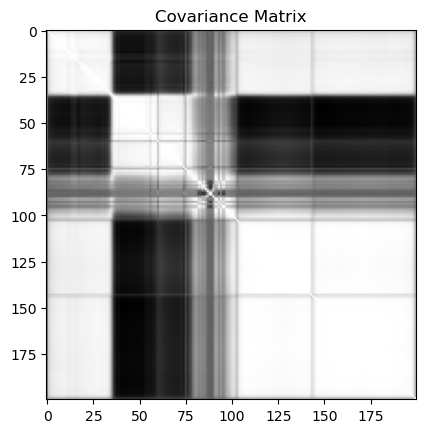

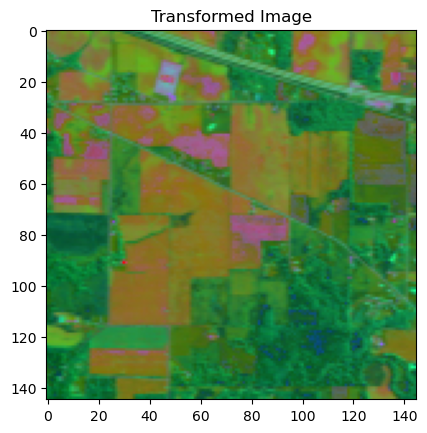

In [11]:
img = scale_image(img, scaler=StandardScaler())
pcc, img_pc = pca(img)

In [12]:
"""
Create a pandas DataFrame from pixel row, pixel column, spectral bands, and class labels.
"""
pix_row = pd.Series([i for i in range(r_in) for _ in range(c_in)])
pix_col = pd.Series([j for _ in range(r_in) for j in range(c_out)])
bands = [pd.Series(img_pc[:, :, i].ravel()) for i in range(img_pc.shape[2])]

df = pd.concat(
    [pd.Series(pix_row.values.reshape(-1)), 
     pd.Series(pix_col.values.reshape(-1)), 
     *bands, 
     pd.Series(out_.reshape(-1))], 
    axis=1)

df.columns = ['pixel_row', 'pixel_col'] + [f'band-{i+1}' for i in range(img_pc.shape[2])] + ['class']

df.head()

,pixel_row,pixel_col,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,...,band-100,band-101,band-102,band-103,band-104,band-105,band-106,band-107,band-108,class
0,0,0,10.573985,4.212713,0.188368,0.453512,-0.708530,1.269551,0.557866,-0.671861,...,-0.005764,-0.137948,0.032568,0.017613,-0.023743,0.148547,0.050400,0.029244,0.083758,3
1,0,1,13.157707,-1.954412,0.154367,-1.221876,-1.546592,0.789850,-1.345252,-0.705247,...,-0.016431,-0.052116,-0.009060,0.161088,0.069522,0.057546,-0.047618,-0.045962,0.060955,3
2,0,2,14.070350,-3.843906,0.100992,-2.504653,-1.606242,1.248752,1.674807,-0.168051,...,-0.034366,0.024022,0.098636,0.136803,0.057617,-0.070731,-0.042873,-0.060359,0.139894,3
3,0,3,13.356123,-2.583363,0.308769,-1.442995,-1.720049,0.683605,-0.889717,-0.698483,...,-0.038637,-0.032398,0.007657,-0.058535,0.109683,-0.095049,-0.099040,0.039866,0.064724,3
4,0,4,11.591195,1.749463,0.002845,0.556080,-1.187322,0.981349,-0.642878,-1.173312,...,-0.050431,-0.005268,0.051648,-0.020921,-0.018609,-0.105329,-0.025060,-0.050484,0.114516,3


In [13]:
X = df.loc[:, 'band-1':'band-'+str(pcc)].values
y = df['class'].values
count_occurrence(y)
X.shape, y.shape #flattened data

0 = 10776
1 = 46
2 = 1428
3 = 830
4 = 237
5 = 483
6 = 730
7 = 28
8 = 478
9 = 20
10 = 972
11 = 2455
12 = 593
13 = 205
14 = 1265
15 = 386
16 = 93


((21025, 108), (21025,))

In [14]:
def classifier(X_train, y_train, X_test, y_test, classifier, gridsearch=False, silence=False):
    """
    Trains and evaluates a classifier on the given training and test data.

    Parameters:
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Test data features.
    - y_test (array-like): Test data labels.
    - classifier (str): The classifier to use. Supported classifiers are 'svc', 'knn', and 'rfc'.
    - gridsearch (bool): Whether to perform grid search for hyperparameter tuning. Default is False.
    - silence (bool): Whether to suppress printing of accuracy scores. Default is False.

    Returns:
    - y_pred (array-like): Predicted labels for the test data.
    - scr (float): Test accuracy score.
    - clf (object): Trained classifier object.
    """
    if classifier.lower() == 'svc':
        if gridsearch:
            param_grid = {
                'C': [0.1, 1, 10, 100, 1000], 
                'gamma': ['scale'], 
                'kernel': ['rbf']
            }
            clf = GridSearchCV(SVC(random_state=42), param_grid, refit = True, verbose = 3)
        else:
            clf = SVC(C = 100, kernel='rbf', random_state=42, gamma = 'scale')
    elif classifier.lower() == 'knn':
        if gridsearch:
            param_grid = {
                'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19], 
                'weights': ['uniform', 'distance'], 
                'metric': ['euclidean', 'manhattan']
            }
            clf = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3)
        else:
            clf = KNeighborsClassifier(metric='manhattan', n_neighbors = 9, weights='distance')
    elif classifier.lower() == 'rfc':
        if gridsearch:
            param_grid = {
                'n_estimators': [50, 80, 110, 140, 170, 200, 230], 
                #'max_features': ['auto', 'sqrt', 'log2']
            }
            clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, refit = True, verbose = 3)
        else:
            clf = RandomForestClassifier(n_estimators=150, random_state=42)
    else:
        raise ValueError("Invalid classifier. Supported classifiers are 'svc', 'knn' and 'rfc'.")
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scr = clf.score(X_test, y_test)
    
    if not silence and gridsearch:
        print(f"Best Parameters: {clf.best_params_}")
        print(f"Training Accuracy: {clf.best_score_}")
        print(f"Test Accuracy: {scr}")
    elif not silence and not gridsearch:
        print(f"Test Accuracy: {scr}")
    
    return y_pred, scr, clf


In [15]:
X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X, y,  range(X.shape[0]), test_size = 0.25)

y_pred_svc, scr_svc, clf_svc = classifier(X_train, y_train, X_test, y_test, 'svc', gridsearch=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.614 total time=  10.5s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.612 total time=   9.8s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.620 total time=  10.7s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.615 total time=  15.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.622 total time=  23.8s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.741 total time=  22.1s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.738 total time=  19.1s
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.747 total time=  18.3s
[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.749 total time=  10.4s
[CV 5/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.741 total time=  11.3s
[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.811 total time=   7.4s
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;,

In [16]:
y_pred_knn, scr_knn, clf_knn = classifier(X_train, y_train, X_test, y_test, 'knn', gridsearch=True)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.711 total time=   0.8s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.697 total time=   0.3s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.722 total time=   0.3s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.711 total time=   0.3s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.719 total time=   0.3s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.715 total time=   0.2s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.691 total time=   0.2s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.719 total time=   0.2s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.711 total time=   0.2s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.719 to

In [17]:
y_pred_rfc, scr_rfc, clf_rfc = classifier(X_train, y_train, X_test, y_test, 'rfc', gridsearch=True)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[CV 1/5] END ...................n_estimators=50;, score=0.710 total time=  25.7s
[CV 2/5] END ...................n_estimators=50;, score=0.713 total time=  25.3s
[CV 3/5] END ...................n_estimators=50;, score=0.709 total time=  25.4s
[CV 4/5] END ...................n_estimators=50;, score=0.713 total time=  25.2s
[CV 5/5] END ...................n_estimators=50;, score=0.706 total time=  25.7s
[CV 1/5] END ...................n_estimators=80;, score=0.713 total time=  39.5s
[CV 2/5] END ...................n_estimators=80;, score=0.717 total time=  38.9s
[CV 3/5] END ...................n_estimators=80;, score=0.717 total time=  39.9s
[CV 4/5] END ...................n_estimators=80;, score=0.726 total time=  40.0s
[CV 5/5] END ...................n_estimators=80;, score=0.710 total time=  40.5s
[CV 1/5] END ..................n_estimators=110;, score=0.719 total time=  55.4s
[CV 2/5] END ..................n_estimators=110;, score=0.719 total time=  49.4s
[CV 3/5] END ...............

In [18]:
def clmap(y_pred, title, dim):
    """
    Plot the classification map for the predicted labels.

    Parameters:
    y_pred (array-like): Predicted labels for the test data.
    """    
    clmap = [0]*X.shape[0]
    clmap = [y[idx] if idx in indices_train else clmap[i] for i, idx in enumerate(range(X.shape[0]))]
    clmap = [y_pred[indices_test.index(i)] if i in indices_test else clmap[i] for i in range(X.shape[0])]
    clmap = np.array(clmap).reshape(dim)
    clmap_training = clmap * (gt != 0)
    sp.imshow(classes = clmap_training, title='Training Classification Map - '+title)
    training_errors = clmap_training * (clmap_training != gt)
    sp.imshow(classes = training_errors, title='Training Errors - '+title)

c:\Users\aiqia\anaconda3\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


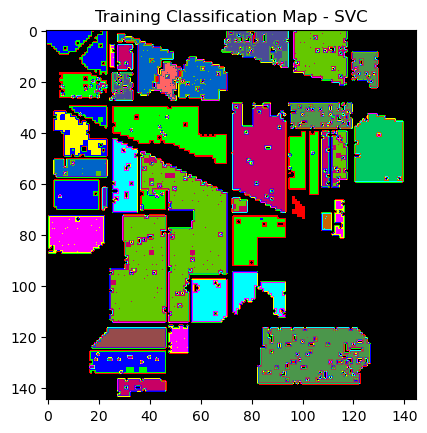

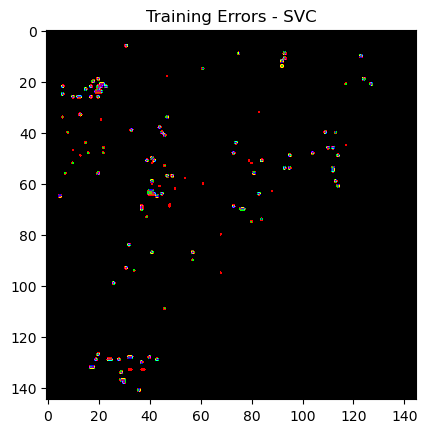

In [19]:
clmap(y_pred_svc, 'SVC', (r_in, c_in))

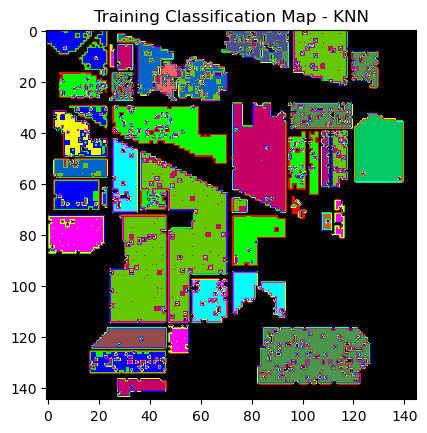

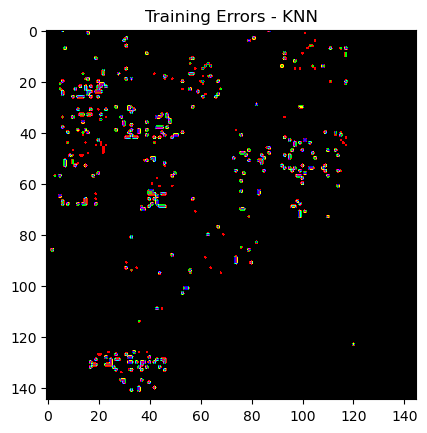

In [20]:
clmap(y_pred_knn, 'KNN', (r_in, c_in))

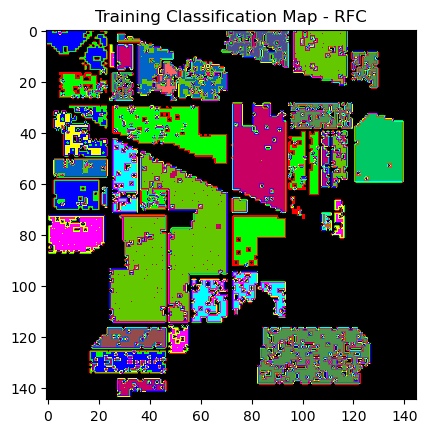

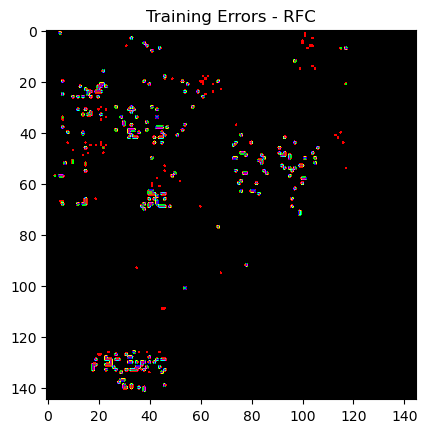

In [21]:
clmap(y_pred_rfc, 'RFC', (r_in, c_in))

In [22]:
def plot_classification_report(y_pred, title):
    print('Classification Report - '+ title)
    print('Accuracy: %.2f %%' % (accuracy_score(y_test, y_pred) * 100))
    print(classification_report(y_test, y_pred))

    skplt.metrics.plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix - '+title, figsize=(7,5), cmap='Greens')

In [23]:
def plot_classification_map(y_pred, title):
    clmap = [0]*X.shape[0]
    clmap = [y[idx] if idx in indices_train else clmap[i] for i, idx in enumerate(range(X.shape[0]))]
    clmap = [y_pred[indices_test.index(i)] if i in indices_test else clmap[i] for i in range(X.shape[0])]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(np.array(clmap).reshape((145, 145)), cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title('Classification Map - ' + title)

    plt.subplot(1, 2, 2)
    plt.imshow(out_, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title('True Map')

    plt.tight_layout()
    plt.show()

In [24]:
def other_metrics(y_pred, title):
    #loss = log_loss(y_test, y_pred, labels=np.unique(y_test))

    lb = LabelBinarizer()
    lb.fit(y_test)

    y_true_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)

    roc_auc = roc_auc_score(y_true_bin, y_pred_bin, multi_class='ovr')

    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    print('Other Metrics - ' + title)
    #print('Log Loss: {}'.format(loss))
    print('AUC-ROC: {}'.format(roc_auc))
    print('Matthews Correlation Coefficient: {}'.format(mcc))
    print("Cohen's Kappa: {}".format(kappa))

Classification Report - SVC
Accuracy: 82.90 %
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2691
           1       0.82      0.90      0.86        10
           2       0.83      0.81      0.82       366
           3       0.86      0.81      0.84       204
           4       0.79      0.62      0.69        53
           5       0.88      0.80      0.84       110
           6       0.92      0.82      0.87       179
           7       1.00      1.00      1.00         6
           8       0.90      0.92      0.91       103
           9       0.75      0.50      0.60         6
          10       0.75      0.77      0.76       233
          11       0.84      0.84      0.84       650
          12       0.88      0.87      0.88       153
          13       0.98      1.00      0.99        51
          14       0.65      0.54      0.59       321
          15       0.50      0.33      0.40        90
          16       0.93      0.81  

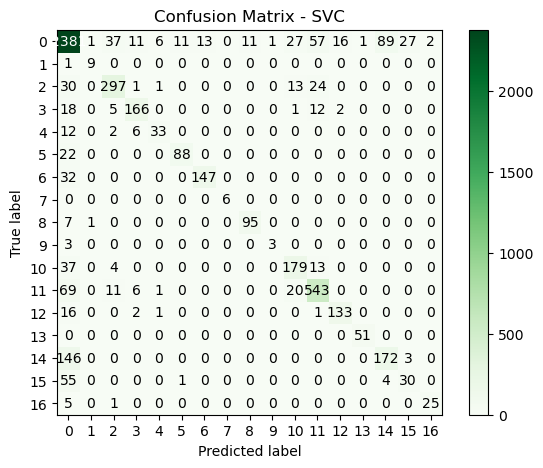

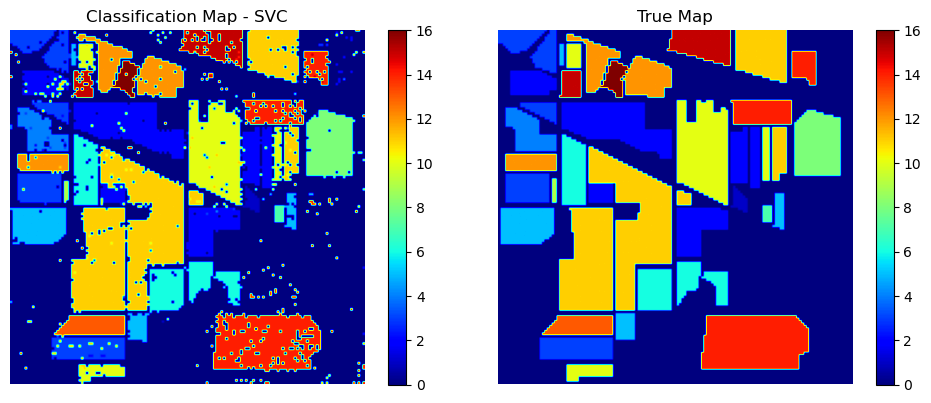

Other Metrics - SVC
AUC-ROC: 0.8810977716829204
Matthews Correlation Coefficient: 0.7543800295406753
Cohen's Kappa: 0.7537428300266774


In [25]:
plot_classification_report(y_pred_svc, 'SVC')
plot_classification_map(y_pred_svc, 'SVC')
other_metrics(y_pred_svc, 'SVC')

Classification Report - KNN
Accuracy: 73.69 %
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2691
           1       1.00      0.10      0.18        10
           2       0.61      0.58      0.59       366
           3       0.65      0.52      0.58       204
           4       0.52      0.32      0.40        53
           5       0.78      0.71      0.74       110
           6       0.70      0.70      0.70       179
           7       1.00      0.67      0.80         6
           8       0.74      0.96      0.84       103
           9       0.00      0.00      0.00         6
          10       0.61      0.71      0.66       233
          11       0.65      0.83      0.73       650
          12       0.65      0.59      0.62       153
          13       0.84      0.96      0.90        51
          14       0.57      0.44      0.50       321
          15       0.38      0.03      0.06        90
          16       0.90      0.61  

c:\Users\aiqia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aiqia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aiqia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


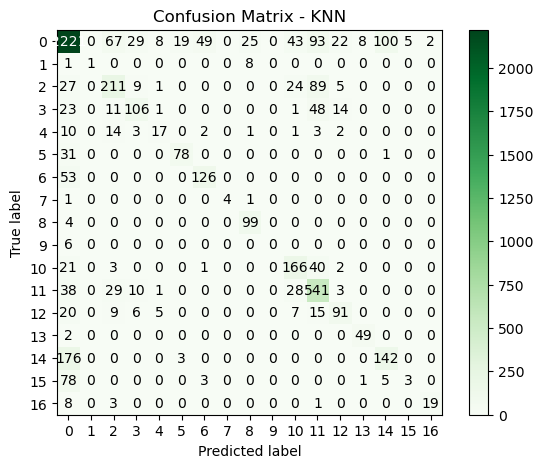

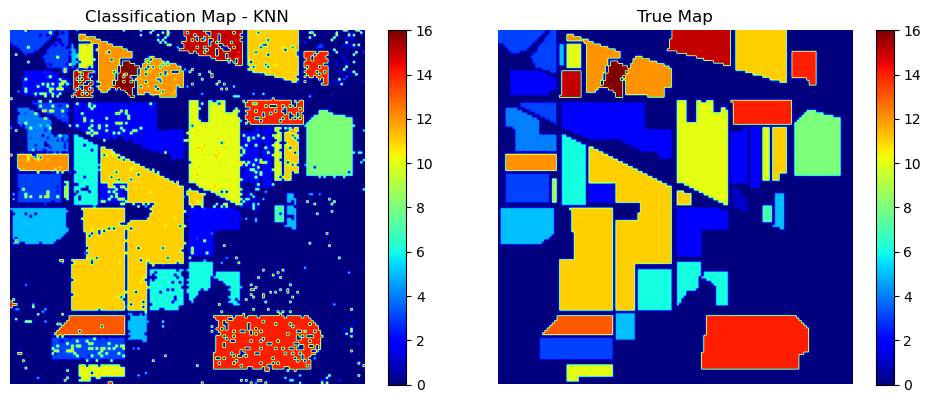

Other Metrics - KNN
AUC-ROC: 0.7704718492590619
Matthews Correlation Coefficient: 0.6258808435772972
Cohen's Kappa: 0.6250359920900178


In [26]:
plot_classification_report(y_pred_knn, 'KNN')
plot_classification_map(y_pred_knn, 'KNN')
other_metrics(y_pred_knn, 'KNN')

Classification Report - RFC
Accuracy: 72.36 %
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      2691
           1       0.00      0.00      0.00        10
           2       0.62      0.57      0.60       366
           3       0.80      0.37      0.51       204
           4       0.38      0.06      0.10        53
           5       0.96      0.49      0.65       110
           6       0.96      0.29      0.45       179
           7       0.00      0.00      0.00         6
           8       0.87      0.95      0.91       103
           9       0.00      0.00      0.00         6
          10       0.79      0.57      0.66       233
          11       0.65      0.81      0.72       650
          12       0.87      0.44      0.59       153
          13       0.97      0.63      0.76        51
          14       0.68      0.16      0.26       321
          15       0.00      0.00      0.00        90
          16       1.00      0.35  

c:\Users\aiqia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aiqia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aiqia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


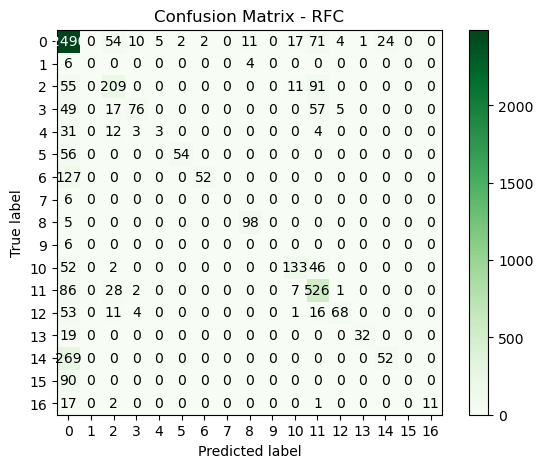

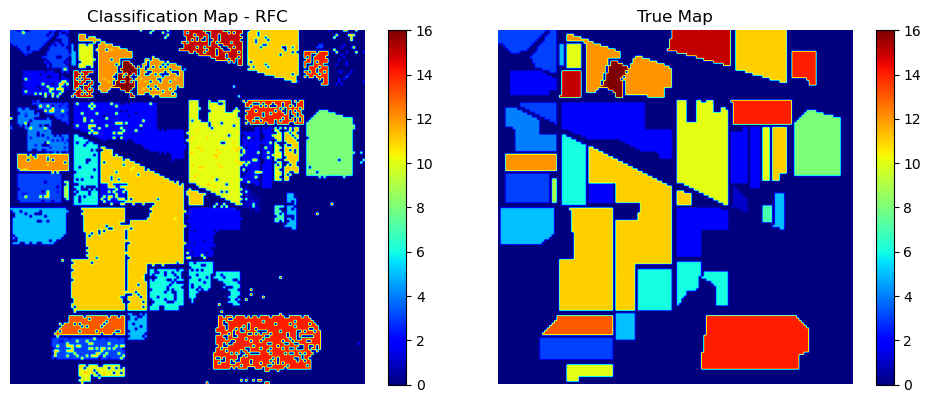

Other Metrics - RFC
AUC-ROC: 0.681042450528887
Matthews Correlation Coefficient: 0.5832823667204531
Cohen's Kappa: 0.5676077971674947


In [27]:
plot_classification_report(y_pred_rfc, 'RFC')
plot_classification_map(y_pred_rfc, 'RFC')
other_metrics(y_pred_rfc, 'RFC')